# Что такое Neural Style Transfer?

**Neural Style Transfer (NST)** — это метод компьютерного зрения, который использует нейронные сети для переноса стиля с одного изображения (например, картины) на другое (например, фотографию), сохраняя при этом его содержание.

Пример NTS:

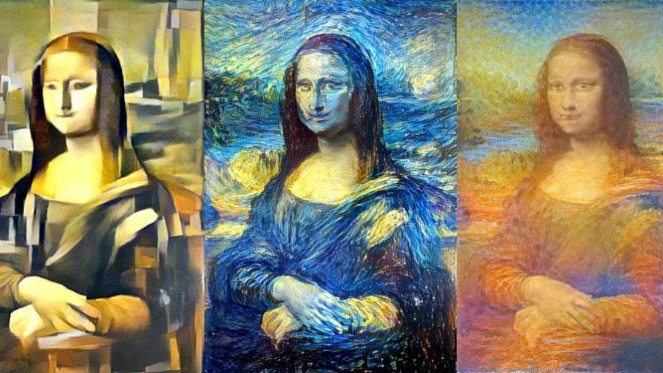

## Основные теории и подходы NST

### 🔹 Как это работает?

**NST** использует свёрточные нейронные сети (CNN), чаще всего предобученные (например, VGG-19), чтобы разделить и перекомбинировать содержание и стиль изображений.

**Содержание (Content)** – это основные объекты и структура изображения (например, здание, человек, пейзаж).

**Стиль (Style)** – это текстуры, цвета и художественные особенности (например, мазки кисти, как у Ван Гога).

**NST** оптимизирует новое изображение так, чтобы:

Его активации в глубоких слоях CNN соответствовали содержанию исходного изображения.

Его статистика активаций (грам-матрицы) в разных слоях CNN соответствовала стилю целевого изображения.

### 🔹 Основные шаги алгоритма

**Выбор модели:** Обычно берут предобученную CNN (например, VGG-19).

**Извлечение признаков:**

Содержание кодируется активациями глубоких слоёв (например, conv4_2).

Стиль кодируется через грам-матрицы активаций в нескольких слоях (например, conv1_1, conv2_1, conv3_1).

**Оптимизация:**

Создаётся случайное изображение (или копия контентного).

Минимизируется общая потеря (total_loss = α * content_loss + β * style_loss).

Оптимизатор (например, L-BFGS или Adam) постепенно изменяет изображение.

###  🔹 Почему используется VGG-19?

- Это сверточная нейросеть, обученная на изображениях из ImageNet.
- Она хорошо выделяет важные признаки:
  - Низкие слои → цвета, линии (для стиля)
  - Глубокие слои → формы, контуры (для контента)
- Мы не обучаем её заново — просто **используем как извлекатель признаков (feature extractor)**.

### 🔹 Какие есть подходы?

Медленный (оптимизационный) NST (Gatys et al., 2015) – итеративная оптимизация пикселей.

Быстрый (feed-forward) NST – обучение генеративной сети (например, на основе U-Net или Transformers) для мгновенного переноса стиля.

Перенос стиля в реальном времени (например, Prisma, DeepArt).

### 🔹 Примеры применения

Художественная обработка фото (как фильтры в приложениях).

Генерация уникального дизайна (текстиль, интерьеры).

Видео-стилизация (перенос стиля на кадры).

# Реализация Neural Style Transfer на PyTorch

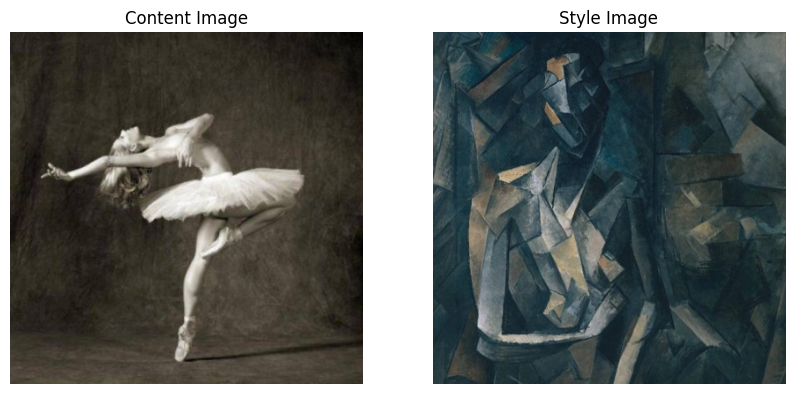

Step 500, Total loss: 301.8008


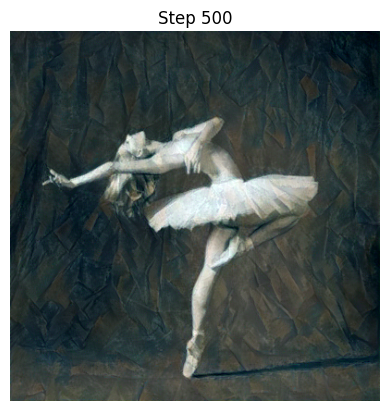

Step 1000, Total loss: 95.6238


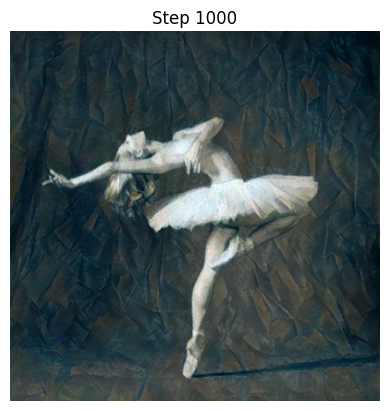

Step 1500, Total loss: 72.8858


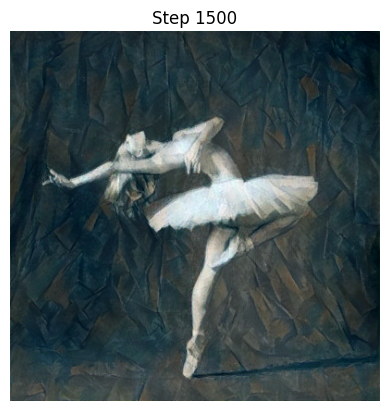

Step 2000, Total loss: 61.2740


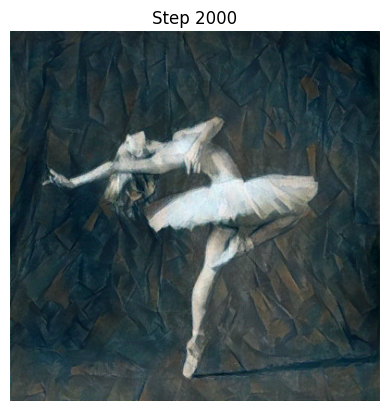

In [ ]:
# Реализация Neural Style Transfer на PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import copy
import requests
from io import BytesIO

# Проверка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Функция загрузки изображения
def load_image(url, max_size=400, shape=None):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert('RGB')

    if shape is not None:
        size = shape  # tuple: (h, w)
    else:
        size = max_size if max(image.size) > max_size else max(image.size)

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    image = in_transform(image)[:3, :, :].unsqueeze(0)
    return image.to(device)

# Визуализация изображения
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    image = image.clip(0, 1)
    return image

# Грама-матрица
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(c, h * w)
    G = torch.mm(features, features.t())
    return G / (c * h * w)

# Загрузка изображений (можно заменить на свои URL)
content_url = 'https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg'
style_url = 'https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg'

content = load_image(content_url)
style = load_image(style_url, shape=(content.shape[-2], content.shape[-1]))


# Визуализация
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(im_convert(content))
plt.title("Content Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(im_convert(style))
plt.title("Style Image")
plt.axis("off")
plt.show()

# Загрузка модели
vgg = models.vgg19(pretrained=True).features.to(device).eval()

# Замораживаем веса
for param in vgg.parameters():
    param.requires_grad_(False)

# Выбор слоев для контента и стиля
content_layers = ['conv4_2']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

# Имя слоя к номеру
def get_features(image, model, layers=None):
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if layers is not None:
            if name in layers:
                features[layers[name]] = x
    return features

# Карта имен слоев
layer_map = {'0': 'conv1_1',
             '5': 'conv2_1',
             '10': 'conv3_1',
             '19': 'conv4_1',
             '21': 'conv4_2',
             '28': 'conv5_1'}

# Извлекаем признаки
content_features = get_features(content, vgg, layer_map)
style_features = get_features(style, vgg, layer_map)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_layers}

# Начальное изображение — копия контентного
target = content.clone().requires_grad_(True).to(device)

# Оптимизация
style_weight = 1e9
content_weight = 0
optimizer = optim.Adam([target], lr=0.003)

# Обучение
steps = 2000
for i in range(1, steps+1):
    target_features = get_features(target, vgg, layer_map)

    # Content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

    # Style loss
    style_loss = 0
    for layer in style_layers:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_loss = torch.mean((target_gram - style_gram) ** 2)
        style_loss += layer_loss

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Визуализация прогресса
    if i % 500 == 0:
        print(f"Step {i}, Total loss: {total_loss.item():.4f}")
        plt.imshow(im_convert(target))
        plt.title(f"Step {i}")
        plt.axis("off")
        plt.show()